# Feasibility UQ: single-param method

Take the generic DEMO solution, turned into an input file. Remove f-values at iteration vars, and replace their equality constraints with inequalities. Run PROCESS once-through with uncertain inputs, and the QoI as the value of constraints, i.e. the feasibility.

Use the single-param method to try to screen out parameters that don't have a large effect on the feasibility, to prioritise for the Sobol analysis.

In [1]:
import easyvvuq as uq
import chaospy as cp
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

## Campaign to capture feasibility

Using the epistemic uncertain inputs for the entire code, capture the distribution of constraint residuals.

In [2]:
# Define campaign
WORK_DIR = "campaigns"
Path("campaigns").mkdir(exist_ok=True)
campaign = uq.Campaign(name="model_inputs", work_dir=WORK_DIR)

# Define parameter space
# Uncertainties from Alex's SA paper

params = {
    "fdene": {
        "type": "float",
        "min": 1.1,
        "max": 1.3,
        "default": 1.2,
    },  # check: not sure if this is right var. I think ok
    "hfact": {"type": "float", "min": 1.0, "max": 1.2, "default": 1.2},
    "coreradius": {"type": "float", "min": 0.45, "max": 0.75, "default": 0.75},  # ok
    "fimp_2": {"type": "float", "min": 0.085, "max": 0.115, "default": 0.1},  # ok
    "fimp_14": {
        "type": "float",
        "min": 1.0e-5,
        "max": 1.0e-4,
        "default": 1.0e-5,
    },  # ok
    "psepbqarmax": {"type": "float", "min": 8.7, "max": 9.7, "default": 9.0}, # ok
    "flhthresh": {"type": "float", "min": 0.85, "max": 1.15, "default": 1.15},  # ok
    "cboot": {
        "type": "float",
        "min": 0.95,
        "max": 1.05,
        "default": 1.0,
    },  # ok
    "peakfactrad": {"type": "float", "min": 2.0, "max": 3.5, "default": 3.33}, # ok
    "kappa": {"type": "float", "min": 1.8, "max": 1.9, "default": 1.848},  # ok
    "etaech": {"type": "float", "min": 0.3, "max": 0.5, "default": 0.4}, # ok
    "feffcd": {"type": "float", "min": 0.5, "max": 5.0, "default": 1.0}, # ok
    "etath": {"type": "float", "min": 0.36, "max": 0.4, "default": 0.375}, # ok
    "etaiso": {"type": "float", "min": 0.75, "max": 0.95, "default": 0.9}, # ok
    "boundl_18": {
        "type": "float",
        "min": 3.25,
        "max": 3.75,
        "default": 3.25,
    },  # q^95_min, ok
    "pinjalw": {"type": "float", "min": 51.0, "max": 61.0, "default": 61.0}, # ok
    "alstroh": {"type": "float", "min": 6.0e8, "max": 7.2e8, "default": 6.6e8}, # ok
    "sig_tf_wp_max": {
        "type": "float",
        "min": 5.2e8,
        "max": 6.4e8,
        "default": 6.4e8,
    },  # ok, but might need sig_tf_case_max to be the same too
    "aspect": {"type": "float", "min": 3.0, "max": 3.2, "default": 3.1},
    "boundu_2": {
        "type": "float",
        "min": 11.0,
        "max": 12.0,
        "default": 12.0,
    },  # B_T^max, ok
    "triang": {"type": "float", "min": 0.4, "max": 0.6, "default": 0.5}, # ok
    "vary_param": {
        "type": "string",
        "default": "",
    },  # param being changed: used for analysis only
}

# In Graeme's but not mine
# ralpne: not in Alex's paper
# sig_tf_case_max
# walalw: not in Alex's paper

# QoIs
# Violated constraint residuals
qois = [
    "vio_constr_res",
]

# Create encoder and decoder
encoder = uq.encoders.GenericEncoder(
    template_fname="demo_sol_no_f_IN.template", target_filename="IN.DAT"
)
decoder = uq.decoders.JSONDecoder(
    target_filename="constraints.json", output_columns=qois
)

cmd = "process -i IN.DAT"
actions = uq.actions.local_execute(encoder, cmd, decoder)

# Add the app
campaign.add_app(name="feasibility", params=params, actions=actions)

Create a sampler for single-parameter sampling.

In [3]:
# Dict of params to be varied: ready for dataframe conversion
vary = {param: [] for param in params}

# Remove vary_param: want to add manually
# Might need to be a copy
filtered_params = params.copy()
filtered_params.pop("vary_param")

for vary_key, vary_value in filtered_params.items():
    if vary_key in ["vary_param"]:
        continue

    # Set label
    vary["vary_param"].append(vary_key)

    # Set min sample for this param
    vary[vary_key].append(vary_value["min"])
    for const_key, const_value in filtered_params.items():
        # Ignore value we're varying
        if vary_key == const_key:
            continue
        # Add value to be held constant
        vary[const_key].append(const_value["default"])

    vary["vary_param"].append(vary_key)

    # Set max sample for this param
    vary[vary_key].append(vary_value["max"])
    for const_key, const_value in filtered_params.items():
        # Ignore value we're varying
        if vary_key == const_key:
            continue
        # Add value to be held constant
        vary[const_key].append(const_value["default"])

samples = pd.DataFrame(vary)
# samples

In [4]:
dataframe_sampler = uq.sampling.DataFrameSampler(samples)

# Add sampler to campaign
campaign.set_sampler(dataframe_sampler)
print(f"Number of samples = {dataframe_sampler.n_samples()}", flush=True)

# Draw samples, execute and collate
campaign.execute().collate(progress_bar=True)
results = campaign.get_collation_result()

Number of samples = 42


  0%|          | 0/42 [00:00<?, ?it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
The IN.DAT file does not contain any obsolete variables.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1139-gb6082f03a
    Branch : feasibility-uq
   Git log : Dump violated constraint residuals to JSON
 Date/time : 15 Jun 2023 11:19:53 +01:00(hh:mm) UTC
    

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


Constraints: constrs = array([ 1.87631631e-02, -3.62447413e-02, -4.61166467e-06,  8.33369422e-02,
        6.82883032e-01, -5.20897960e-02,  4.78012732e-01,  6.18861155e-01,
       -1.80327869e-01,  3.99570979e-01,  5.80030392e-01,  3.78529705e-01,
        1.60860679e+01,  1.27277377e+01,  4.49067883e+00, -2.33375542e-05,
       -1.78656936e-05,  3.05398329e+00,  2.33606972e+00,  7.57683363e-02,
        2.88883953e-01,  1.27499397e-05,  2.85158316e-01,  3.96871845e-06,
       -4.90705053e-01, -2.76584551e-05,  1.28658857e-01])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.2554E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than 

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
  2%|▏         | 1/42 [00:02<01:51,  2.72s/it]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1139-gb6082f03a
    Branch : feasibility-uq
   Git log : Dump violated constraint residuals to JSON
 Date/time : 15 Jun 2023 11:19:54 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :

  5%|▍         | 2/42 [00:02<00:48,  1.21s/it]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
Constraints: constrs = array([ 1.39867678e-02, -7.95296097e-03, -4.61166467e-06,  3.33125600e-06,
        7.05529184e-01, -3.93339965e-02,  2.90596489e-01,  3.40144127e-01,
       -1.80327869e-01,  3.55157518e-01,  5.75656342e-01,  3.78529705e-01,
        1.60860679e+01,  1.27277377e+01,  4.49067883e+00, -2.33375542e-05,
       -1.78656936e-05,  3.05398329e+00,  2.33606972e+00,  2

 12%|█▏        | 5/42 [00:03<00:20,  1.79it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
Constraints: constrs = array([ 1.87631631e-02, -6.19181260e-02, -4.61166467e-06,  3.33125600e-06,
        6.82883032e-01, -5.20897960e-02,  4.78012732e-01,  6.18861155e-01,
       -1.80327869e-01,  3.99570979e-01,  5.80030392e-01,  3.78529705e-01,
        1.60860679e+01,  1.27277377e+01,  4.49067883e+00, -2.33375542e-05,
       -1.78656936e-05,  3.05398329e+00,  2.33606972e+00,  1.42207225e-01,
        2.88883953e-01,  1.27499397e-05,  2.85158316e-01,  3.96871845e-06,
       -4.90705053e-01, -2.76584551e-05,  1.28658857e-01])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.2554E+00
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 
 tmargmin_cs has been ignored.
 
 ********************

 14%|█▍        | 6/42 [00:04<00:21,  1.70it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1139-gb6082f03a
    Branch : feasibility-uq
   Git log : Dump violated constraint residuals to JSON
 Date/time : 15 Jun 2023 11:19:56 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.2554E+00
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
Constraints: constrs = array([ 1.87631631e-02, -3.62447413e-02, -4.61166467e-06,  3.33125600e-06,
        6.82883032e-01, -5.20897960e-02,  4.78012732e-01,  6.18861155e-01,
       -1.80327869e-0

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 17%|█▋        | 7/42 [00:05<00:22,  1.57it/s]

 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 **************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ************

 19%|█▉        | 8/42 [00:05<00:19,  1.74it/s]

Constraints: constrs = array([ 1.87631631e-02,  1.18265800e-01, -4.61166467e-06,  3.33125600e-06,
        6.82883032e-01, -5.20897960e-02,  4.78012732e-01,  6.18861155e-01,
       -1.80327869e-01,  3.99570979e-01,  5.80030392e-01,  3.78529705e-01,
        1.60860679e+01,  1.27277377e+01,  4.49067883e+00, -2.33375542e-05,
       -1.78656936e-05,  3.05398329e+00,  2.33606972e+00,  2.90922004e-01,
        2.88883953e-01,  1.27499397e-05,  2.85158316e-01,  3.96871845e-06,
       -4.90705053e-01, -2.76584551e-05,  1.28658857e-01])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.2554E+00


process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 24%|██▍       | 10/42 [00:05<00:10,  2.94it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
Constraints: constrs = array([ 1.87631631e-02, -3.62447413e-02, -4.61166467e-06,  3.33125600e-06,
        6.82883032e-01, -5.20897960e-02,  4.78012732e-01,  7.18288680e-01,
       -1.80327869e-01,  3.99570979e-01,  5.80030392e-01,  3.78529705e-01,
        1.60860679e+01,  1.27277377e+01,  4.49067883e+00, -2.33375542e-05,
       -1.78656936e-05,  3.05398329e+00,  2.33606972e+00,  7

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 26%|██▌       | 11/42 [00:06<00:10,  2.85it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1139-gb6082f03a
    Branch : feasibility-uq
   Git log : Dump violated constraint residuals to JSON
 Date/time : 15 Jun 2023 11:19:58 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


Constraints: constrs = array([ 1.87631631e-02, -3.62447413e-02, -4.61166467e-06,  3.33125600e-06,
        6.82883032e-01, -5.20897960e-02,  4.78012732e-01,  6.18861155e-01,
       -1.80327869e-01,  3.99570979e-01,  5.80030392e-01,  3.78529705e-01,
        1.60860679e+01,  1.27277377e+01,  4.49067883e+00, -2.33375542e-05,
       -1.78656936e-05,  3.05398329e+00,  2.33606972e+00,  7.57683363e-02,
        2.88883953e-01,  1.27499397e-05,  2.85158316e-01,  3.96871845e-06,
       -4.90705053e-01, -2.76584551e-05,  1.28658857e-01])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.2554E+00
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ********

 33%|███▎      | 14/42 [00:07<00:08,  3.11it/s]

The IN.DAT file does not contain any obsolete variables.
Constraints: constrs = array([ 1.87631631e-02, -3.62447413e-02, -4.61166467e-06,  3.33125600e-06,
        6.82883032e-01, -5.20897960e-02,  4.78012732e-01,  6.18861155e-01,
       -1.80327869e-01,  3.99570979e-01,  5.80030392e-01,  3.78529705e-01,
        1.60860679e+01,  1.27277377e+01,  4.49067883e+00, -2.33375542e-05,
       -1.78656936e-05,  3.05398329e+00,  2.33606972e+00,  7.57683363e-02,
        2.88883953e-01,  1.27499397e-05,  2.85158316e-01,  3.96871845e-06,
       -4.90705053e-01, -2.76584551e-05,  1.28658857e-01])
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.2554E+00
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **********************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 36%|███▌      | 15/42 [00:07<00:09,  2.86it/s]

 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1139-gb6082f03a
    Branch : feasibility-uq
   Git log : Dump violated constraint residuals to JSON
 Date/time : 15 Jun 2023 11:19:59 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebooks/vvuq/feasibility/campaigns/model_inputsrrgve0he/runs/runs_0-100000000/runs_0-1000000/runs_

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 43%|████▎     | 18/42 [00:08<00:07,  3.37it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
Constraints: constrs = array([ 3.22450856e-02, -7.67604093e-03, -4.61166467e-06, -4.80579474e-02,
        6.42601335e-01, -5.93802475e-02,  5.52651054e-01,  6.31245893e-01,
       -1.80327869e-01,  4.14493079e-01,  5.23705037e-01,  3.78529705e-01,
        1.60482033e+01,  1.27981673e+01,  4.49067883e+00,  1.58501389e-02,
       -1.78656936e-05,  3.05398329e+00,  2.34440574e+00,  1.04728275e-01,
        2.88883953e-01,  2.29604799e-03,  2.88092678e-01,  6.46077524e-02,
       -5.02896683e-01, -2.76584551e-05,  1.28658857e-01])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3878E+00
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **********************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 45%|████▌     | 19/42 [00:09<00:10,  2.16it/s]

Constraints: constrs = array([ 1.87631631e-02, -3.62447413e-02, -4.61166467e-06,  3.33125600e-06,
        6.82883032e-01, -5.20897960e-02,  4.78012732e-01,  6.18861155e-01,
       -1.80327869e-01,  3.99570979e-01,  5.80030392e-01,  3.78529705e-01,
        1.60860679e+01,  1.27277377e+01,  4.49067883e+00, -2.33375542e-05,
       -1.78656936e-05,  3.05398329e+00,  2.33606972e+00,  7.57683363e-02,
        2.88883953e-01,  1.27499397e-05,  2.85158316e-01,  3.96871845e-06,
       -4.90705053e-01, -2.76584551e-05,  1.28658857e-01])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.2554E+00
The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **********************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 48%|████▊     | 20/42 [00:09<00:09,  2.33it/s]

 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 *********************************************************************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 50%|█████     | 21/42 [00:10<00:09,  2.25it/s]

Constraints: constrs = array([ 1.87631631e-02, -3.62447413e-02, -4.61166467e-06,  3.33125600e-06,
        6.82883032e-01, -5.20897960e-02,  4.78012732e-01,  6.18861155e-01,
       -1.80327869e-01,  3.99570979e-01,  5.80030392e-01,  3.78529705e-01,
        1.60860679e+01,  1.27277377e+01,  4.49067883e+00, -2.33375542e-05,
       -1.78656936e-05,  3.05398329e+00,  2.33606972e+00,  7.57683363e-02,
        2.88883953e-01,  1.27499397e-05,  2.85158316e-01,  3.96871845e-06,
       -4.90705053e-01, -2.76584551e-05,  1.28658857e-01])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.2554E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than 

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 57%|█████▋    | 24/42 [00:10<00:05,  3.52it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1139-gb6082f03a
    Branch : feasibility-uq
   Git log : Dump violated constraint residuals to JSON
 Date/time : 15 Jun 2023 11:20:03 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :

 60%|█████▉    | 25/42 [00:11<00:05,  3.19it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1139-gb6082f03a
    Branch : feasibility-uq
   Git log : Dump violated constraint residuals to JSON
 Date/time : 15 Jun 2023 11:20:03 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 62%|██████▏   | 26/42 [00:12<00:07,  2.14it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
The IN.DAT file does not contain any obsolete variables.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1139-gb6082f03a
    Branch : feasibility-uq
   Git log : Dump violated constraint residuals to JSON
 Date/time : 15 Jun 2023 11:20:04 +01:00(hh:mm) UTC
    

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


Constraints: constrs = array([ 1.87631631e-02, -3.62447413e-02, -4.61166467e-06,  3.33125600e-06,
        6.82883032e-01, -5.20897960e-02,  4.78012732e-01,  6.18861155e-01,
       -1.80327869e-01,  3.99570979e-01,  5.80030392e-01,  3.78529705e-01,
        1.60860679e+01,  1.27277377e+01,  4.49067883e+00, -2.33375542e-05,
       -1.78656936e-05,  3.05398329e+00,  2.33606972e+00,  7.57683363e-02,
        2.88883953e-01,  1.27499397e-05,  2.85158316e-01,  3.96871845e-06,
       -4.90705053e-01, -2.76584551e-05,  1.28658857e-01])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.2554E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than 

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


The IN.DAT file does not contain any obsolete variables.
Constraints: constrs = array([ 1.87631631e-02, -3.62447413e-02, -4.61166467e-06,  3.33125600e-06,
        6.82883032e-01, -5.20897960e-02,  4.78012732e-01,  6.18861155e-01,
       -1.80327869e-01,  2.94110961e-01,  5.80030392e-01,  3.78529705e-01,
        1.60860679e+01,  1.27277377e+01,  4.49067883e+00, -2.33375542e-05,
       -1.78656936e-05,  3.05398329e+00,  2.33606972e+00,  7.57683363e-02,
        2.88883953e-01,  1.27499397e-05,  2.85158316e-01,  3.96871845e-06,
       -4.90705053e-01, -2.76584551e-05,  1.28658857e-01])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.2554E+00
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **********************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 67%|██████▋   | 28/42 [00:13<00:06,  2.13it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


Constraints: constrs = array([ 1.87631631e-02, -3.62447413e-02, -4.61166467e-06,  3.33125600e-06,
        6.82883032e-01, -5.20897960e-02,  4.78012732e-01,  6.18861155e-01,
       -1.80327869e-01,  3.99570979e-01,  5.80030392e-01,  3.78529705e-01,
        1.60860679e+01,  1.27277377e+01,  4.49067883e+00, -2.33375542e-05,
       -1.78656936e-05,  3.05398329e+00,  2.33606972e+00,  7.57683363e-02,
        2.88883953e-01,  1.27499397e-05,  2.85158316e-01,  3.96871845e-06,
       -4.90705053e-01, -2.76584551e-05,  1.28658857e-01])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.2554E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than 

 69%|██████▉   | 29/42 [00:13<00:05,  2.31it/s]

Constraints: constrs = array([ 1.87631631e-02, -3.62447413e-02, -4.61166467e-06,  3.33125600e-06,
        6.82883032e-01, -5.20897960e-02,  4.78012732e-01,  6.18861155e-01,
       -1.80327869e-01,  3.99570979e-01,  5.80030392e-01,  3.78529705e-01,
        1.60860679e+01,  1.27277377e+01,  4.49067883e+00, -2.33375542e-05,
       -1.78656936e-05,  3.05398329e+00,  2.33606972e+00,  7.57683363e-02,
        2.88883953e-01, -9.08975001e-02,  2.85158316e-01,  3.96871845e-06,
       -4.90705053e-01, -2.76584551e-05,  1.28658857e-01])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.2554E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than 

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 71%|███████▏  | 30/42 [00:13<00:04,  2.81it/s]

The IN.DAT file does not contain any obsolete variables.
The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.


 74%|███████▍  | 31/42 [00:14<00:03,  2.82it/s]

 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1139-gb6082f03a
    Branch : feasibility-uq
   Git log : Dump violated constraint residuals to JSON
 Date/time : 15 Jun 2023 11:20:06 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebooks/vvuq/feasibility/campaigns/model_inputsrrgve0he/runs/runs_0-100000000/runs_0-1000000/runs_0-10000/runs_0-100/run_37/IN.DAT
This is longer than 110 columns.


process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 76%|███████▌  | 32/42 [00:14<00:04,  2.43it/s]

Constraints: constrs = array([ 1.18627179e-02, -6.73236740e-02,  1.07480765e-02,  1.06230768e-02,
        6.42195865e-01, -1.03943872e-01,  3.72478240e-01,  6.25864926e-01,
       -1.80327869e-01,  5.15179818e-01,  6.34527166e-01,  3.78529705e-01,
        1.62430563e+01,  1.26319973e+01,  4.48730493e+00, -2.80615389e-02,
       -1.78656936e-05,  3.05210608e+00,  2.32467723e+00,  3.11383821e-02,
        2.07071340e-01, -3.08885457e-03,  2.81172314e-01, -1.34421842e-02,
       -5.29752192e-01, -1.88950708e-03,  1.26213596e-01])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   plascur =    2.1403E+07  normalised_total_beta =    3.1237E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma dri

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1139-gb6082f03a
    Branch : feasibility-uq
   Git log : Dump violated constraint residuals to JSON
 Date/time : 15 Jun 2023 11:20:07 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 79%|███████▊  | 33/42 [00:15<00:04,  2.06it/s]

 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 **************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 81%|████████  | 34/42 [00:15<00:03,  2.50it/s]

 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
Constraints: constrs = array([ 2.49583148e-02, -5.52853083e-03, -1.00852568e-02, -9.18153533e-03,
        7.24391293e-01,  1.67693808e-03,  5.83236940e-01,  6.11726741e-01,
       -1.80327869e-01,  2.91859494e-01,  5.29197349e

 83%|████████▎ | 35/42 [00:16<00:03,  2.25it/s]

 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1139-gb6082f03a
    Branch : feasibility-uq
   Git log : Dump violated constraint residuals to JSON
 Date/time : 15 Jun 2023 11:20:08 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebooks/vvuq/feasibility/campaigns/model_inputsrrgve0he/runs/runs_0-100000000/runs_0-1000000/runs_

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 88%|████████▊ | 37/42 [00:16<00:01,  3.56it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
Constraints: constrs = array([ 1.87631631e-02, -3.62447413e-02, -4.61166467e-06,  3.33125600e-06,
        6.82883032e-01, -5.20897960e-02,  4.78012732e-01,  6.18861155e-01,
       -1.80327869e-01,  3.99570979e-01,  5.80030392e-01,  3.78529705e-01,
        1.60860679e+01,  1.27277377e+01,  4.49067883e+00, -2.33375542e-05,
       -1.78656936e-05,  3.05398329e+00,  2.33606972e+00,  7

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 90%|█████████ | 38/42 [00:16<00:01,  3.31it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 **************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 98%|█████████▊| 41/42 [00:16<00:00,  5.54it/s]

Constraints: constrs = array([ 1.87631631e-02, -3.62447413e-02, -4.61166467e-06,  3.33125600e-06,
        6.82883032e-01, -5.20897960e-02,  4.78012732e-01,  6.18861155e-01,
       -1.80327869e-01,  3.99570979e-01,  5.80030392e-01,  3.78529705e-01,
        1.60860679e+01,  1.27277377e+01,  4.49067883e+00, -2.33375542e-05,
       -1.78656936e-05,  3.05398329e+00,  2.33606972e+00,  7.57683363e-02,
        2.88883953e-01,  1.27499397e-05,  2.85158316e-01,  3.96871845e-06,
       -4.90705053e-01, -2.76584551e-05,  1.28658857e-01])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.2554E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than 

100%|██████████| 42/42 [00:17<00:00,  2.45it/s]


In [5]:
results

,run_id,iteration,fdene,hfact,coreradius,fimp_2,fimp_14,psepbqarmax,flhthresh,cboot,...,etaiso,boundl_18,pinjalw,alstroh,sig_tf_wp_max,aspect,boundu_2,triang,vary_param,vio_constr_res
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,1,0,1.1,1.2,0.75,0.100,0.00001,9.0,1.15,1.00,...,0.90,3.25,61.0,660000000.0,640000000.0,3.1,12.0,0.5,fdene,0.102674
1,2,0,1.3,1.2,0.75,0.100,0.00001,9.0,1.15,1.00,...,0.90,3.25,61.0,660000000.0,640000000.0,3.1,12.0,0.5,fdene,0.101414
2,3,0,1.2,1.0,0.75,0.100,0.00001,9.0,1.15,1.00,...,0.90,3.25,61.0,660000000.0,640000000.0,3.1,12.0,0.5,hfact,0.103702
3,4,0,1.2,1.2,0.75,0.100,0.00001,9.0,1.15,1.00,...,0.90,3.25,61.0,660000000.0,640000000.0,3.1,12.0,0.5,hfact,0.101414
4,5,0,1.2,1.2,0.45,0.100,0.00001,9.0,1.15,1.00,...,0.90,3.25,61.0,660000000.0,640000000.0,3.1,12.0,0.5,coreradius,0.101873
5,6,0,1.2,1.2,0.75,0.100,0.00001,9.0,1.15,1.00,...,0.90,3.25,61.0,660000000.0,640000000.0,3.1,12.0,0.5,coreradius,0.101414
6,7,0,1.2,1.2,0.75,0.085,0.00001,9.0,1.15,1.00,...,0.90,3.25,61.0,660000000.0,640000000.0,3.1,12.0,0.5,fimp_2,0.101414
7,8,0,1.2,1.2,0.75,0.115,0.00001,9.0,1.15,1.00,...,0.90,3.25,61.0,660000000.0,640000000.0,3.1,12.0,0.5,fimp_2,0.101414
8,9,0,1.2,1.2,0.75,0.100,0.00001,9.0,1.15,1.00,...,0.90,3.25,61.0,660000000.0,640000000.0,3.1,12.0,0.5,fimp_14,0.101414


In [6]:
# Extract the single-param values for each varied parameter
vary_params = results[("vary_param", 0)].unique().tolist()
vio_constr_res_diff_dict = {"vary_params": [], "vio_constr_res_diffs": []}

for vary_param in vary_params:
    # Get violated constraint residuals for this varied parameter's min and max samples
    vio_constr_res_series = results[results[("vary_param", 0)] == vary_param][
        "vio_constr_res", 0
    ]
    vio_constr_res = vio_constr_res_series.to_list()
    # Calc diff and add to new dict
    vio_constr_res_diff = abs(vio_constr_res[1] - vio_constr_res[0])
    vio_constr_res_diff_dict["vary_params"].append(vary_param)
    vio_constr_res_diff_dict["vio_constr_res_diffs"].append(vio_constr_res_diff)

vio_constr_res_diffs_df = pd.DataFrame(vio_constr_res_diff_dict)
vio_constr_res_diffs_df = vio_constr_res_diffs_df.sort_values(
    "vio_constr_res_diffs", ascending=False
).reset_index(drop=True)

Text(0.5, 0, 'RMS of violated constraint residuals')

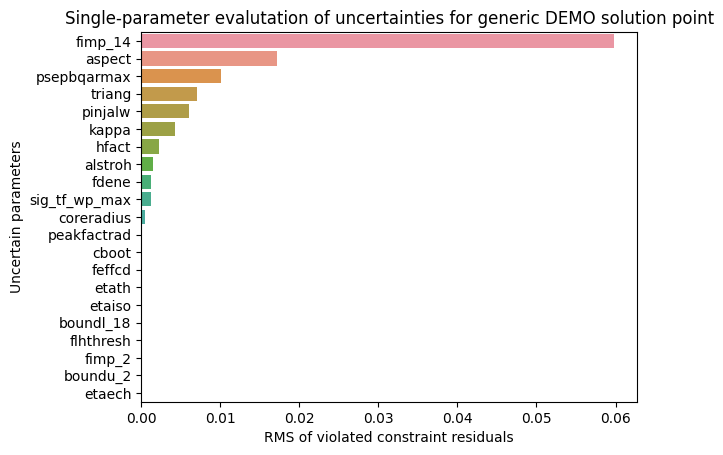

In [11]:
fig, ax = plt.subplots()
sns.barplot(data=vio_constr_res_diffs_df, x="vio_constr_res_diffs", y="vary_params", ax=ax)
ax.set_title("Single-parameter evalutation of uncertainties for generic DEMO solution point")
ax.set_ylabel("Uncertain parameters")
ax.set_xlabel("RMS of violated constraint residuals")

After varying each single parameter in turn from min to max, this shows the change in violated constraint residuals. These are the parameters that produce the greatest changes in the violated constraints, and will be selected for Sobol analysis.

In [8]:
vio_constr_res_diffs_df[vio_constr_res_diffs_df["vio_constr_res_diffs"] > 0]

,vary_params,vio_constr_res_diffs
0,fimp_14,0.059763
1,aspect,0.017154
2,psepbqarmax,0.010107
3,triang,0.007064
4,pinjalw,0.006048
5,kappa,0.004203
6,hfact,0.002288
7,alstroh,0.001498
8,fdene,0.001260
9,sig_tf_wp_max,0.001249


For Sobol analysis on all 11/21 params that affect the feasibility, `4**11 ~= 4e6`, which is too many samples. Try `4**8 ~= 6e4` instead.